# Progressive Dinner Party Mathematical Program

# Setup

### AMPL

Set up the AMPL modelling environment.

Connect to NEOS Server with the Kestrel interface or use a locally installed solver by connecting this notebook to a local runtime:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0`

In [ ]:
!pip install -q amplpy

### Imports

In [19]:
import itertools
import numpy as np
import networkx as nx
import ipywidgets as widgets
import matplotlib.pyplot as plt

from amplpy import AMPL

# Model

In [20]:
%%writefile pdp.mod
problem progressive_dinner_party;
#--------------------------------

set N;
set T = {N,N,N};
param C{N,N};
param o = 1/card(N);

var s{N} binary;
var m{N} binary;
var d{N} binary;
var e{N,N} binary;
var t{(i,j,k) in T} = s[i]*m[j]*d[k];

minimize objective:
	sum {i in N, j in N} C[i,j]*e[i,j];

subject to classes {i in N}:
	s[i] + m[i] + d[i] = 1;
	
subject to inflow_s {i in N}:
	sum {j in N} s[i] * e[j,i] = 0;
	
subject to outflow_s {i in N}:
	sum {j in N} s[i] * e[i,j] = 3 * s[i];
	
subject to inflow_m {i in N}:
	sum {j in N} m[i] * e[j,i] = 3 * m[i];
	
subject to outflow_m {i in N}:
	sum {j in N} m[i] * e[i,j] = 3 * m[i];
	
subject to inflow_d {i in N}:
	sum {j in N} d[i] * e[j,i] = 3 * d[i];
	
subject to outflow_d {i in N}:
	sum {j in N} d[i] * e[i,j] = 0;
	
subject to shortcut {i in N, j in N}:
	s[i] * e[i,j] + d[j] <= 1;
	
subject to equipartition:
	3 * sum {i in N} m[i] = card(N);

subject to encounters {(i,j,k) in T}:
	sum {(u,v,w) in T: i <> u and j <> v and k <> w} t[i,j,k]*t[u,v,w] * (3 - floor(abs(i-u)/(abs(i-u)-o)) - floor(abs(j-v)/(abs(j-v)-o)) - floor(abs(k-w)/(abs(k-w)-o))) <= t[i,j,k];

Overwriting pdp.mod


# Data

In [33]:
w_size = widgets.IntText(description='Size', orientation='horizontal', value=9, min=9)
w_cluster = widgets.IntText(description='Clusters', orientation='horizontal', value=1, min=1)
w_deviation = widgets.FloatText(description='Deviation', orientation='horizontal', value=0.1, min=0)
w_scale = widgets.IntText(description='Scaling', orientation='horizontal', value=1)
display(widgets.Box([w_size, w_cluster,w_deviation, w_scale], layout=widgets.Layout(display='flex', flex_flow='row')))

Box(children=(IntText(value=9, description='Size'), IntText(value=1, description='Clusters'), FloatText(value=…

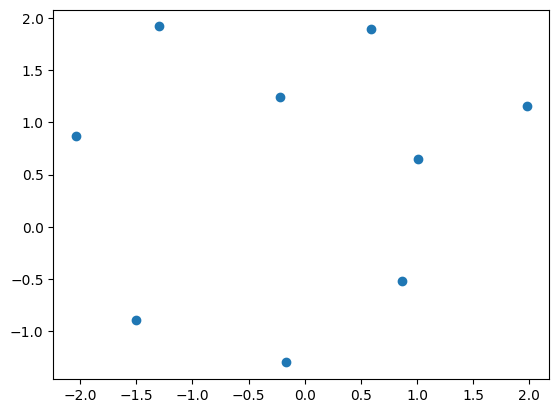

In [58]:
rng = np.random.default_rng()

N = w_size.value
K = w_cluster.value
σ = w_deviation.value
λ = w_scale.value

assert N >= 9
assert K > 0
assert N % K == 0
assert N % 3 == 0
assert σ >= 0
assert λ > 0

points = {}
centers = rng.uniform(-1, 1, (K, 2))
for i in range(K):
	points[str(centers[i])] = λ * rng.normal(centers[i], σ, (N // K, 2))

X = np.array(list(points.values())).reshape(N, 2)[:,0]
Y = np.array(list(points.values())).reshape(N, 2)[:,1]

G = nx.DiGraph()
for i in range(N):
	G.add_node(i, x = X[i], y = Y[i])

C = np.empty((N,N))
for a,b in itertools.product(range(N), range(N)):
	dX = (X[b]-X[a]) * (X[b]-X[a])
	dY = (Y[b]-Y[a]) * (Y[b]-Y[a])
	C[a,b] = np.sqrt(dX + dY)

with open('pdp.dat', 'w') as f:
	f.write('set N :=')
	for n in range(1, N + 1):
		f.write(f' {n}')
	f.write(';\n')
	f.write('param C :=\n')
	for i,j in itertools.product(range(N), range(N)):
		f.write(f'{i+1} {j+1} {C[i,j]}\n')
	f.write(';')

plt.scatter(X,Y)
plt.show()

In [55]:
ampl = AMPL()

In [59]:
ampl.setOption('solver', 'gurobi')
ampl.setOption('gurobi_options', 'outlev=1')
ampl.setOption('solution_round', '0')

In [60]:
ampl.read('pdp.mod')

In [61]:
ampl.read_data('pdp.dat')

In [62]:
ampl.solve()

x-Gurobi 10.0.0: Set parameter OutputFlag to value 1
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 739 rows, 918 columns and 765 nonzeros
Model fingerprint: 0x54ec29a4
Model has 945 quadratic constraints
Variable types: 0 continuous, 918 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 3e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
  QRHS range       [1e+00, 1e+00]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R729 by 1.000000000

Presolve removed 504 rows and 810 columns
Presolve time: 0.01s
Presolved: 397 rows, 189 columns, 1431 nonzeros
Variable types: 

In [63]:
s = ampl.get_variable('s').get_values()
m = ampl.get_variable('m').get_values()
d = ampl.get_variable('d').get_values()
e = ampl.get_variable('e').get_values()

S = np.array(s.get_column('s.val').to_list())
M = np.array(m.get_column('m.val').to_list())
D = np.array(d.get_column('d.val').to_list())
E = np.reshape(e.get_column('e.val').to_list(), (N,N))

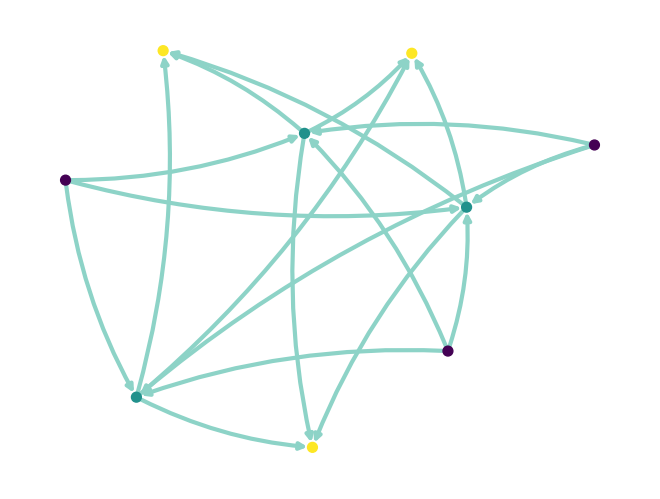

In [64]:
plt.figure(1)
idx_s = [idx for idx, val in enumerate(S) if val == 1]
idx_m = [idx for idx, val in enumerate(M) if val == 1]
idx_d = [idx for idx, val in enumerate(D) if val == 1]


for i,j in itertools.product(range(N),range(N)):
  if E[i,j] == 1: 
    G.add_edge(i, j, color=1)

nodes = dict(G.nodes(data=True))
pos = {k: list(v.values()) for k, v in nodes.items()}

nx.draw(
    G, pos,
    edge_color = nx.get_edge_attributes(G,'color').values(),
    edge_cmap = plt.cm.get_cmap('Set3'),
    node_color = S + 2*M + 3*D,
    width=3, node_size=50, connectionstyle='arc3,rad=0.1')
plt.show()